# TCRP Exercício 03
# Processamento de Imagens
### **Aluno: Ramon Gomes Durães de Oliveira - Matrícula: 2019720188**

# Processamento de Imagens

Abaixo está a lista de técnicas de processamento de imagens introduzidas no seminário.

- Histograma:
    - Normalização
    - Equalização
    - Equalização Local
    - Correção Gama
    - 
- Filtros de Ruído:
    - Gaussiano
    - Sal e Pimenta (mediana, maximo e minimo)
- Extração de Bordas:
    - Sobel 
    - Canny (bordas localizadas e de resposta máxima)
- Local Binary Patterns (extração de informações de textura e contraste locais) + LBP Histogram
- Laplacian decomposition
- Wavelet para imagens
- Hough e detecção de formas
- Operações Morfológicas
- Transformação de Anscombe 
- Filtro bilateral
- Software FIJI
- Image registration
- Invariâncias à translação, rotação e escala

Algumas destas técnicas (e outras que não foram apresentadas) foram selecionadas e aplicadas a 10 diferentes imagens do conjunto de dados fornecido. Abaixo estão os resultados.

# Carregando e Selecionando Imagens Interessantes

O código abaixo carrega 10 imagens pré-selecionadas para o trabalho. A razão para a seleção das imagens abaixo está comentada no código ao lado do nome do arquivo.

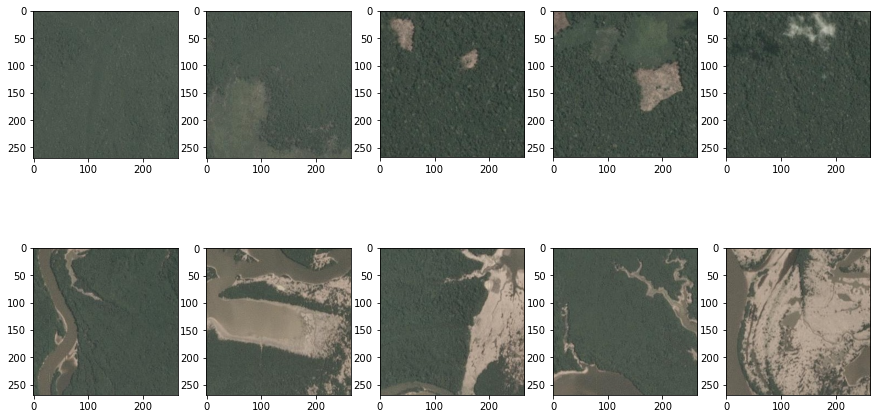

In [262]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import feature

file_names=['./data/row-1-col-3.jpg', ## imagem com baixo contraste, contém apenas árvores.
           './data/row-5-col-1.jpg', ## duas intensidades diferentes de verde para a vegetação
           './data/row-3-col-20.jpg', ## duas áreas desmatadas em meio à área verde 
           './data/row-3-col-14.jpg', ## área desmatada e duas diferentes intensidades de verde
           './data/row-3-col-16.jpg', ## imagem com uma nuvem sobre as árvores ( e sua sombra )
           './data/row-8-col-7.jpg', ## rio bem definido correndo entre as árvores
           './data/row-7-col-6.jpg', ## bordas verticais bem definidas
           './data/row-5-col-3.jpg', ## outro exemplo de imagem bem dividida
           './data/row-4-col-4.jpg', ## nascentes do rio em meio às árvores
           './data/row-8-col-3.jpg'] ## imagem quase toda desmatada

f, axarr = plt.subplots(2,5,figsize=(15,8))
image_list = []
for i in np.arange(0,10):
    image_list.append(Image.open(file_names[i]))
    if i >= 5:
        axarr[1,i%5].imshow(image_list[i])
    else:
        axarr[0,i%5].imshow(image_list[i])

# Processamento de Imagens

## 1. Conversão para escala de cinza

Um ponto interessante mostrado no seminário é que a conversão para imagem em escala de cinza utiliza coeficientes que multiplicam cada canal da imagem. 

$Y' = 0.2126 * R + 0.7152 * G + 0.0722 * B $

Como esta conversão é o primeiro passo para várias tarefas de processamento de imagem, alterarei os coeficientes abaixo para analisar o resultado.

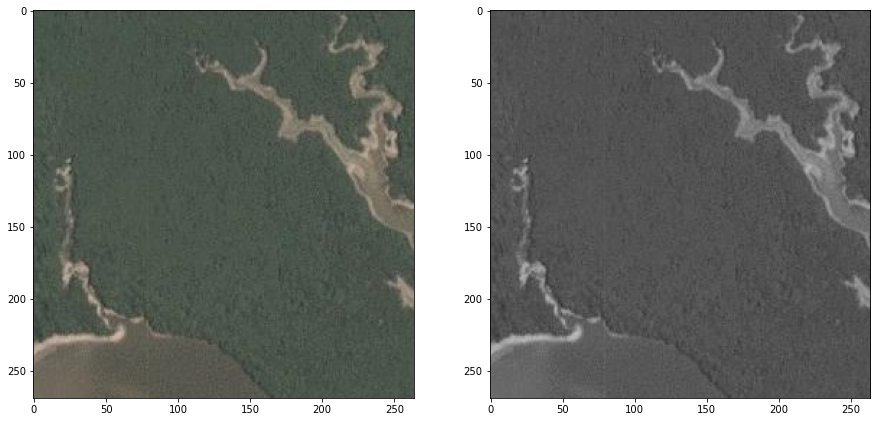

In [216]:
img9 = np.asarray(image_list[8])
gray_img9_array = np.uint8(0.2126 * img9[:,:,0] + 0.7152 * img9[:,:,1] + 0.0722 * img9[:,:,2])
gray_img9 = Image.fromarray(gray_img9_array, 'L')

f, axarr = plt.subplots(1,2,figsize=(15,8))
axarr[0].imshow(image_list[8])
axarr[1].imshow(gray_img9, cmap='gray', vmin=0, vmax=255)

Observando os resultados considerando apenas a intensidade em cada canal de cor (red, green e blue, da esquerda para a direita):

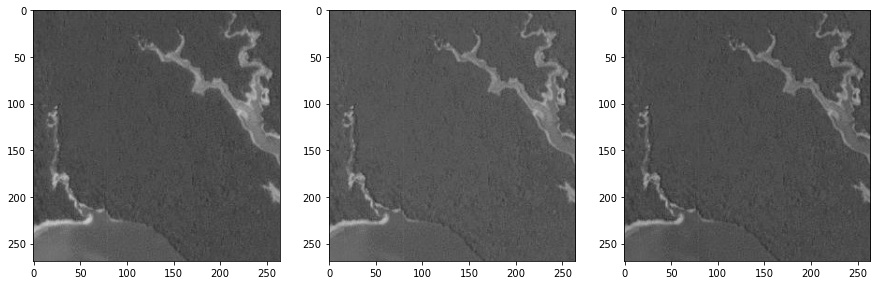

In [217]:
red_img9_array = Image.fromarray(np.uint8(img9[:,:,0]), 'L')
green_img9_array = Image.fromarray(np.uint8(img9[:,:,1]), 'L')
blue_img9_array = Image.fromarray(np.uint8(img9[:,:,2]), 'L')

f, axarr = plt.subplots(1,3,figsize=(15,6))
axarr[0].imshow(red_img9_array, cmap='gray', vmin=0, vmax=255)
axarr[1].imshow(green_img9_array, cmap='gray', vmin=0, vmax=255)
axarr[2].imshow(blue_img9_array, cmap='gray', vmin=0, vmax=255)

Nota-se que os resultados são de fato diferentes, como esperado. Apesar de os coeficientes serem pensados para que a imagem seja mais real para o olho humano, é possível que utilizar valores diferentes para a conversão para escala de cinza facilite a extração de features para uma dada imagem.

## 2. Separação de Canais

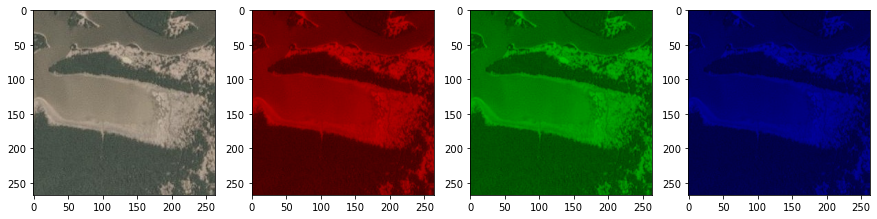

In [74]:
img7 = Image.open('./data/row-7-col-6.jpg')
img7_array = np.asarray(img7)
red_img7 = img7_array.copy()
red_img7[:,:,1] = 1
red_img7[:,:,2] = 1
red_img7_array = Image.fromarray(np.uint8(red_img7))
green_img7 = img7_array.copy()
green_img7[:,:,0] = 1
green_img7[:,:,2] = 1
green_img7_array = Image.fromarray(np.uint8(green_img7))
blue_img7 = img7_array.copy()
blue_img7[:,:,0] = 1
blue_img7[:,:,1] = 1
blue_img7_array = Image.fromarray(np.uint8(blue_img7))

f, axarr = plt.subplots(1,4,figsize=(15,6))
axarr[0].imshow(img7)
axarr[1].imshow(red_img7_array)
axarr[2].imshow(green_img7_array)
axarr[3].imshow(blue_img7_array)

De forma similar, pode ser que ignorar completamente um dos canais de cores leve a resultados melhores. Nas imagens acima, nota-se que os canais vermelho e verde apresentam maior discrepância de cores entre as diferentes regiões (rio, árvores e terra) da imagem.

## 3. Equalização de Histograma

Abaixo é mostrado um exemplo de imagem com pouca variação de contraste entre áreas verdes.

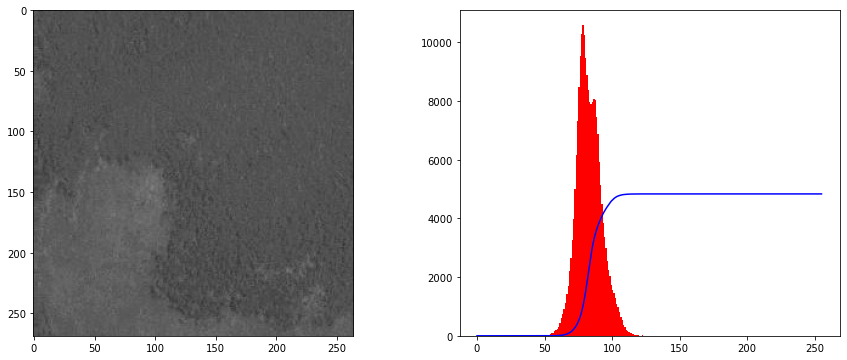

In [109]:
img2 = cv2.imread('./data/row-5-col-1.jpg', 0)
hist,bins = np.histogram(img2.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

f, axarr = plt.subplots(1,2,figsize=(15,6))
axarr[0].imshow(img2, cmap='gray', vmin=0, vmax=255)
axarr[1].plot(cdf_normalized, color = 'b')
axarr[1].hist(img2_array.flatten(),256,[0,256], color = 'r');

É possível aumentar este  contraste por meio da equalização de histograma, como feito abaixo:

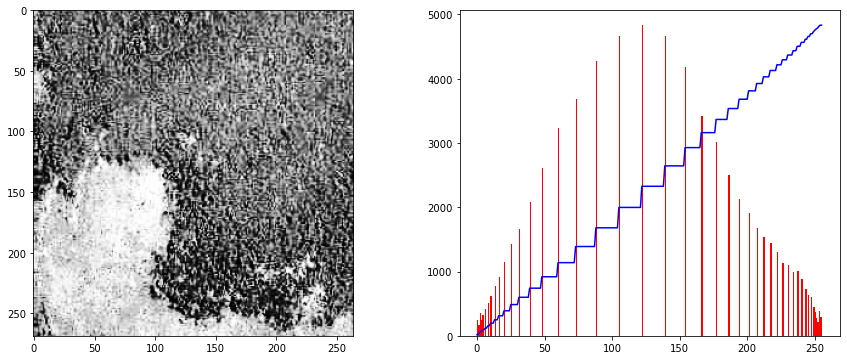

In [110]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

processed_img2 = cdf[img2]

hist2,bins2 = np.histogram(processed_img2.flatten(),256,[0,256])

cdf2 = hist2.cumsum()
cdf2_normalized = cdf2 * hist2.max()/ cdf2.max()

f, axarr = plt.subplots(1,2,figsize=(15,6))
axarr[0].imshow(processed_img2, cmap='gray', vmin=0, vmax=255)
axarr[1].plot(cdf2_normalized, color = 'b')
axarr[1].hist(processed_img2.flatten(),256,[0,256], color = 'r');

Nota-se que se o objetivo é a separação das duas áreas, a equalização de histograma por si só faz a maior parte do trabalho!

## 4. Extração de Bordas: Canny

Algoritmos de extração de bordas detectam apenas as partes de interesse em uma imagem, reduzindo significativamente q quantidade de dados a ser processada. Neste exemplo, utilizamos o algoritmo de Canny, como apresentado no seminário.

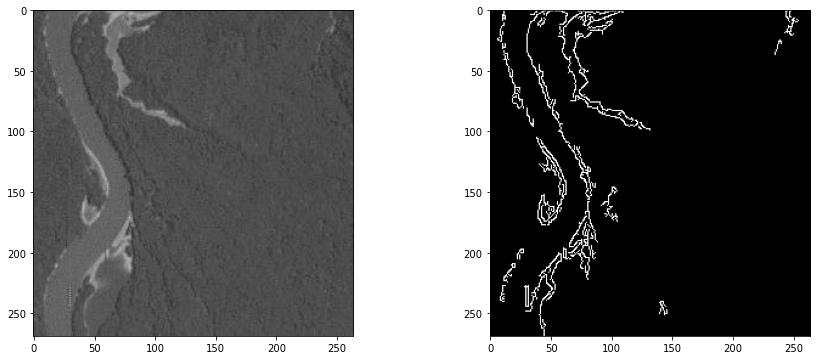

In [218]:
img6_gs = cv2.imread('./data/row-8-col-7.jpg', cv2.IMREAD_GRAYSCALE)

# Apply canny edge detector algorithm on the image to find edges
edges = cv2.Canny(img6_gs, 60,180)

f, axarr = plt.subplots(1,2,figsize=(15,6))
axarr[0].imshow(img6_gs, cmap='gray', vmin=0, vmax=255)
axarr[1].imshow(edges, cmap='gray', vmin=0, vmax=255)

In [129]:
??cv2.Canny

Nota-se que ele faz um bom trabalho na extração das bordas da imagem acima. Os parâmetros de threshold mínimo e máximo pára histerese podem ser ajustados de forma a melhorar ainda mais os resultados:

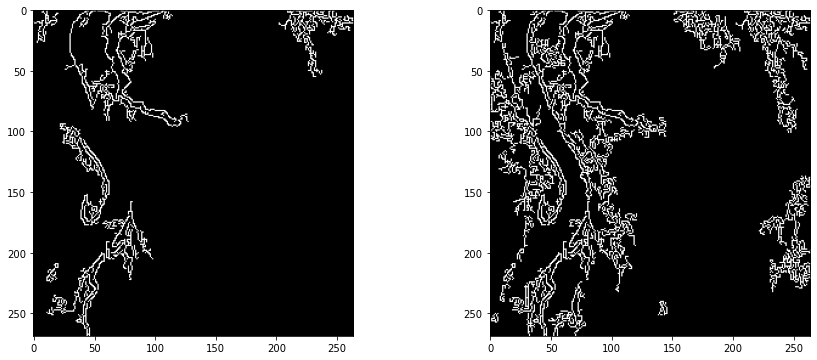

In [219]:
edges2 = cv2.Canny(img6_gs, 1,255)
edges3 = cv2.Canny(img6_gs, 10,150)

f, axarr = plt.subplots(1,2,figsize=(15,6))
axarr[0].imshow(edges2, cmap='gray', vmin=0, vmax=255)
axarr[1].imshow(edges3, cmap='gray', vmin=0, vmax=255)

Os thresholds podem ser ajustados para tornar o algoritmo mais ou menos sensitivo às variações de intensidade na imagem de acordo com a aplicação. 

## 5. Extração de Bordas: Sobel

Text(0.5, 1.0, 'Sobel: filtro na direção Y')

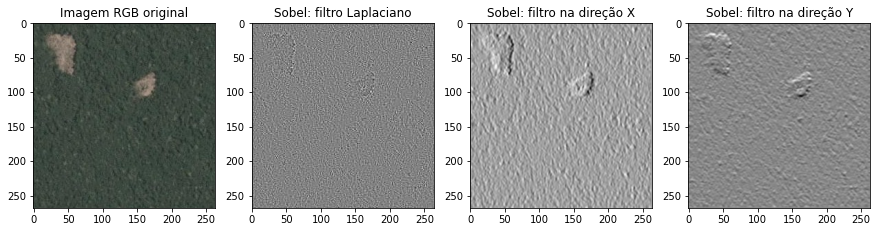

In [220]:
img3 = Image.open('./data/row-3-col-20.jpg')
img3_gs = cv2.imread('./data/row-3-col-20.jpg',0)

laplacian = cv2.Laplacian(img3_gs,cv2.CV_64F)
sobelx = cv2.Sobel(img3_gs,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img3_gs,cv2.CV_64F,0,1,ksize=5)

f, axarr = plt.subplots(1,4,figsize=(15,6))
axarr[0].imshow(img3, cmap = 'gray')
axarr[0].set_title('Imagem RGB original')
axarr[1].imshow(laplacian, cmap = 'gray')
axarr[1].set_title('Sobel: filtro Laplaciano')
axarr[2].imshow(sobelx,cmap = 'gray')
axarr[2].set_title('Sobel: filtro na direção X')
axarr[3].imshow(sobely,cmap = 'gray')
axarr[3].set_title('Sobel: filtro na direção Y')

Uma outra forma de extrair bordas de imagens é utilizando filtros de Sobel. Neste caso, pode-se especificar a direção principal na qual se deseja detectar as bordas. Acima, são exibidos os resultados da aplicação dos filtros de Sobel em uma das imagens fornecidas. Percebe-se que os filtros horizontais, na direção X, são mais evidentes. Em algumas aplicações esta pode ser a direção principal de detecção de bordas.

Em outros casos, como em portões de grades, também pode ser mais eficiente detectar bordas em apenas uma das direções.

## 6. Filtragem de Ruído: Gaussiano

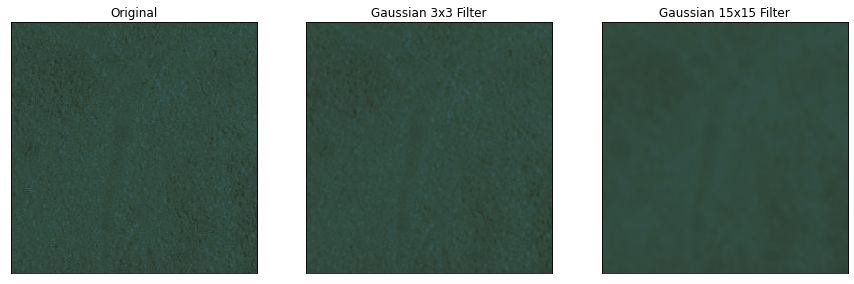

In [228]:
img1 = cv2.imread('./data/row-1-col-3.jpg')
new_image2 = cv2.GaussianBlur(img1, (3, 3),0)
new_image3 = cv2.GaussianBlur(img1, (15, 15),0)

plt.figure(figsize=(15,6))
plt.subplot(131), plt.imshow(cv2.cvtColor(img1, cv2.COLOR_HSV2RGB)),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(cv2.cvtColor(new_image2, cv2.COLOR_HSV2RGB)),plt.title('Gaussian 3x3 Filter')
plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(cv2.cvtColor(new_image3, cv2.COLOR_HSV2RGB)),plt.title('Gaussian 15x15 Filter')
plt.xticks([]), plt.yticks([])
plt.show()

O efeito do filtro Gaussiano é mostrado nas imagens acima. Estas imagens foram escolhidas para mostrar a importância da aplicação das técnicas corretas de acordo com o efeito desejado. Neste caso, nota-se que a imagem, que antes já continha pouca variação de intensidade, contém ainda menos após a aplicação de um filtro gaussiano.

Em um contexto de separação de bordas, por exemplo, o filtro gaussiano bem utilizado pode suavizar bordas menos importantes, aumentando a robustez da detecção de bordas. Neste caso, entretanto, a aplicação cega de um filtro gaussiano apenas piora a situação.

## 7. Filtragem de Ruído: Sal e Pimenta

Diferente do filtro Gaussiano, o filtro de Mediana calcula substitui o pixel pela intensidade mediana de sua vizinhança. Isso o torna melhor que o filtro Gaussiano em algumas ocasiões, como para filtrar ruído de sal e pimenta. Abaixo está uma aplicação deste filtro em uma das imagens fornecidas. 

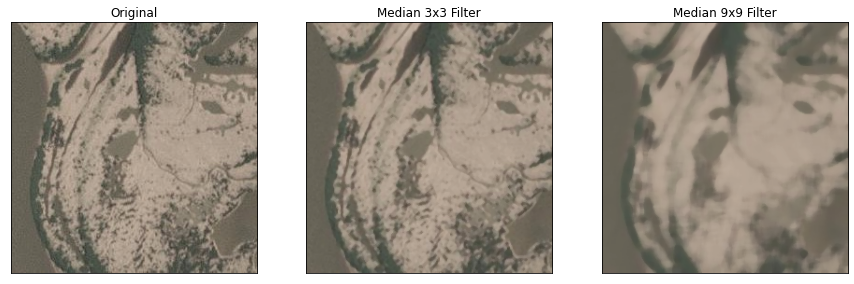

In [237]:
img10 = cv2.imread('./data/row-8-col-3.jpg')
img10 = cv2.cvtColor(img10, cv2.COLOR_BGR2HSV)
new_image2 = cv2.medianBlur(img10, 3)
new_image3 = cv2.medianBlur(img10, 9)

plt.figure(figsize=(15,6))
plt.subplot(131), plt.imshow(cv2.cvtColor(img10, cv2.COLOR_HSV2RGB)),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(cv2.cvtColor(new_image2, cv2.COLOR_HSV2RGB)),plt.title('Median 3x3 Filter')
plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(cv2.cvtColor(new_image3, cv2.COLOR_HSV2RGB)),plt.title('Median 9x9 Filter')
plt.xticks([]), plt.yticks([])
plt.show()

Nota-se que quanto maior a máscara utilizada, mais borrada é a imagem de saída. Porém, este filtro não apenas torna a imagem mais borrada como também remove pequenas pontos de intensidade muito diferente de sua vizinhança. 

Entre as imagens fornecidas, a imagem acima é a que mais se assemelha com uma imagem que teria ruído do tipo "sal e pimenta", pois há várias pequanas áreas de floresta ao longo da área desmatada.

Em uma aplicação na qual deseja-se contabilizar a área desmatada total, pode-se desejar contar esta área com poucas árvores como já desmatada. Neste caso, o filtro de mediana ajudaria a remover estas regiões antes da contabilização das áreas!

## 8. Local Binary Patterns

Tentaremos agora separar as texturas da floresta e da área desmatada utilizando LBP (local binary patterns). Extrairei dois patches da imagem abaixo:

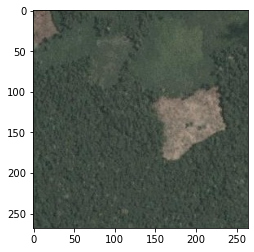

In [180]:
img4 = Image.open('./data/row-3-col-14.jpg')
img4_gs = cv2.imread('./data/row-3-col-14.jpg', cv2.IMREAD_GRAYSCALE)

plt.imshow(img4)

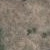

In [196]:
patch_desmatado = np.asarray(img4)[110:160,160:210,:]
patch_desmatado_gs = img4_gs[110:160,160:210]
Image.fromarray(patch_desmatado)

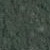

In [198]:
patch_floresta = np.asarray(img4)[200:250,0:50,:]
patch_floresta_gs = img4_gs[200:250,0:50]
Image.fromarray(patch_floresta)

Utilizando as duas amostras acima, calcularemos o histograma do seu local binary pattern.

Text(0.5, 1.0, 'Histograma de Textura: Floresta Desmatada')

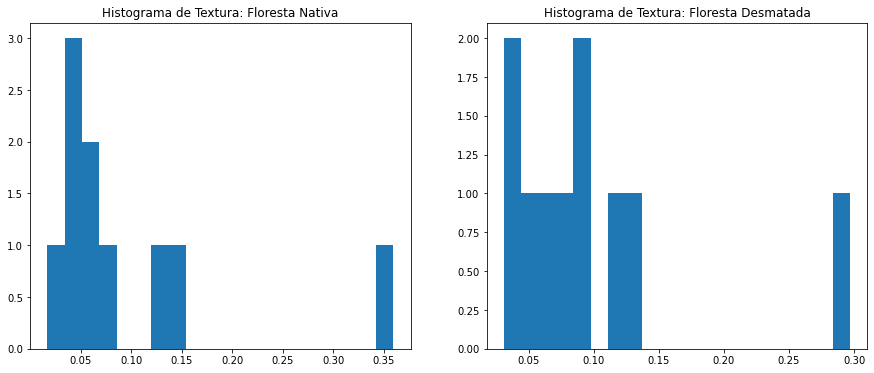

In [215]:
class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        self.numPoints = numPoints
        self.radius = radius
    def describe(self, image, eps=1e-7):
        lbp = feature.local_binary_pattern(image, self.numPoints,
            self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),
            bins=np.arange(0, self.numPoints + 3),
            range=(0, self.numPoints + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        return hist

desc = LocalBinaryPatterns(8, 8)
data = []
labels = []

hist_floresta = desc.describe(patch_floresta_gs)
hist_desmatado = desc.describe(patch_desmatado_gs)

f, axarr = plt.subplots(1,2,figsize=(15,6))
axarr[0].hist(hist_floresta, bins = 20)
axarr[0].set_title('Histograma de Textura: Floresta Nativa')
axarr[1].hist(hist_desmatado, bins = 20)
axarr[1].set_title('Histograma de Textura: Floresta Desmatada')

Percebe-se a diferença evidente entre os histogramas do padrões binários locais destes dois padrões: floresta nativa e desmatada. Tendo estes padrões em mãos, tem-se basicamente um conjunto de treinamento no qual pode-se treinar um classificador para distinguir novas amostras de acordo com o histograma com o qual se parecem mais. 

## 9. Template Matching

Neste exemplo de template matching, vamos extrair manualmente a nuvem da imagem abaixo e tentar utilizar template matching para identificá-la.

Text(0.5, 1.0, 'Nuvem Extraída Manualmente')

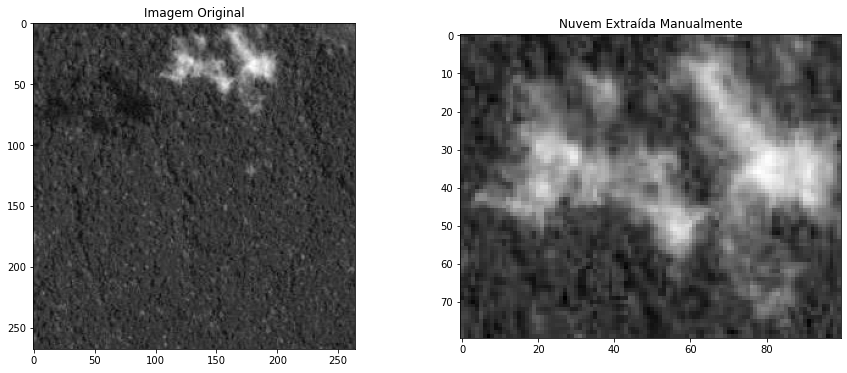

In [254]:
img5 = cv2.imread('./data/row-3-col-16.jpg', 0)
nuvem = img5[0:80,100:200]

f, axarr = plt.subplots(1,2,figsize=(15,6))
axarr[0].imshow(img5, cmap = 'gray')
axarr[0].set_title('Imagem Original')
axarr[1].imshow(nuvem, cmap = 'gray')
axarr[1].set_title('Nuvem Extraída Manualmente')

Agora tentaremos utilizar o template matching da biblioteca scikit-image para identificar esta nuvem na imagem.

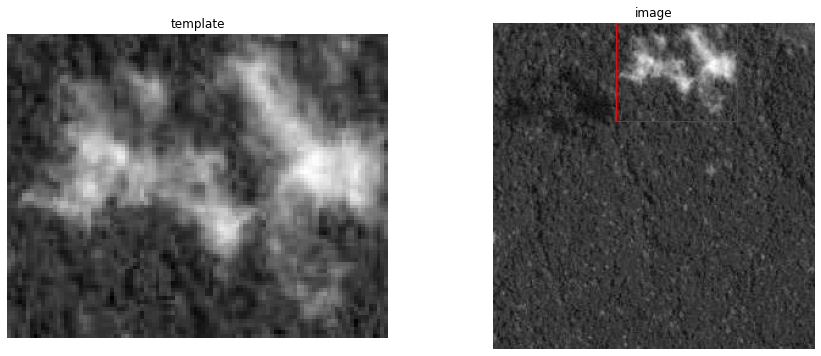

In [259]:
resultado = match_template(img5, nuvem)
ij = np.unravel_index(np.argmax(resultado), resultado.shape)
x, y = ij[::-1]

fig = plt.figure(figsize=(15, 6))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(nuvem, cmap=plt.cm.gray)
ax1.set_axis_off()
ax1.set_title('template')

ax2.imshow(img5, cmap=plt.cm.gray)
ax2.set_axis_off()
ax2.set_title('image')
# highlight matched region
hnuvem, wnuvem = nuvem.shape
rect = plt.Rectangle((x, y), wnuvem, hnuvem, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

plt.show()

Nota-se que, neste exemplo simples, foi possível reconhecer exatamente onde está a nuvem na foto. É claro que este é um exemplo de aplicação simples, mas é possível utilizar esta técnica com sucesso, por exemplo, em indústrias para identificar dígitos de formato pré-conhecido em imagens.

O problema desta técnica, utilizada de maneira tão ingênua, é a falta de invariância. Uma solução para aumentar a robustez da técnica seria utilizar janela deslizante com diversos tamanhos de janela. 

## 10. K-Means 

Indo um pouco mais longe, outra forma de realizar segmentação de imagens é utilizando o algoritmo de clusterização K-Means, citado em sala de aula. Na imagem abaixo, tentaremos separar floresta de área desmatada utilizando um K-Means com K=2.

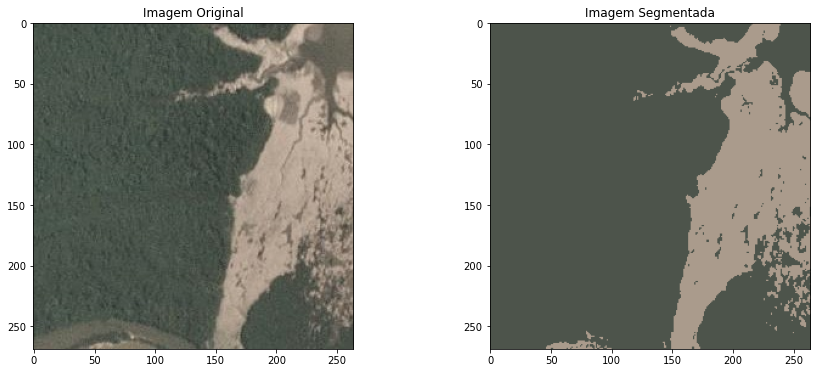

In [280]:
# Carregando a imagem
img8 = cv2.imread('./data/row-5-col-3.jpg')
img8 = cv2.cvtColor(img8, cv2.COLOR_BGR2RGB)

# Transformando em 2D
pixel_values = img8.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# Definindo parâmetros do K-means
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 2
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Mapeando as cores de cada pixel para a cor do cluster ao qual pertencem
centers = np.uint8(centers)
labels = labels.flatten()
segmented_image = centers[labels.flatten()]

# Retornando a imagem a sua forma original 
segmented_image = segmented_image.reshape(img8.shape)

# Plotando o resultado
f, axarr = plt.subplots(1,2,figsize=(15,6))
axarr[0].imshow(img8)
axarr[0].set_title('Imagem Original')
axarr[1].imshow(segmented_image)
axarr[1].set_title('Imagem Segmentada');

Nota-se que, para este exemplo simples, o K-means gera ótimos resultados! Pode-se ainda tentar separar 3 intensidades diferentes para floresta, rio e área desmatada, gerando resultados ainda melhores.